<a id="top"></a>
# Tutorial Title

***

## Learning Goals
Write three to five learning goals. A learning goal should describe what a reader should know or be able to do by the end of the tutorial that they didn't know or couldn't do before.

```
By the end of this tutorial, you will:

- Access data from the Hubble Source Catalog (HSC) and zMAST using astroquery
- Learn how to search for time-variable objects
- Make cutout images in an album style for visual classification.

```

## Introduction
Write a short introduction explaining the purpose of the tutorial. Define any terms or common acronyms that your audience may not know. If you're using some kind of domain-specific astronomical symbol or unusual mathematical concept, make sure you define it (for example, in its mathematical form) and link to any definitions (from literature, Wikipedia, etc.).
The sky is full of transient phenomena - supernovae, variable stars or active galactic nuclei (AGN), tidal disruption events (TDEs).
Of course, looking at every patch of the sky continuously, in the hopes of finding these relatively rare events, is humanly unfeasible. Instead, we can narrow down our regions of interest using pre-existing, or archival, data.
The <a href='https://catalogs.mast.stsci.edu/hsc/'>Hubble Source Catalog</a> 
and <a href='https://z.mast.stsci.edu/'>zMAST</a>
are two rich examples of such databases.
Spend some time on these archives to get a sense for what's available in each of them. Why do you think you might want to use both when looking for transient candidates?
<b>Define an exploration task here.</b>

The interactive websites are a great way to get familiar with the data products. Once you know exactly what numbers/images you want for your analyses, however, a much more efficient way to access these is <a href='https://astroquery.readthedocs.io/en/latest/mast/mast.html'>AstroQuery</a>. This allows you to pull all the fields you like into a single object in Python, that you can manipulate as you go.

## Imports
This tutorial will use the following Python libraries:
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery.mast* to pull data from HSC and zMAST.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astroquery.mast import Mast, Observations, Catalogs, Zcut
from astropy.coordinates import SkyCoord
from astropy import units as u

import astropy, time, sys, os, requests, json

from PIL import Image
from io import BytesIO

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

zMAST contains image cutouts from various surveys: CANDELS, GOODS, the Hubble Frontier Fields and 3D-HST. These surveys were further broken down into fields, or sky regions: GOODS-North and South, the Ultra-Deep Survey (UDS), COSMOS and the Extended Groth Strip (EGS).

candels
candels_master_view 50000


Text(0.5, 1.0, 'zMAST Coverage by Survey')

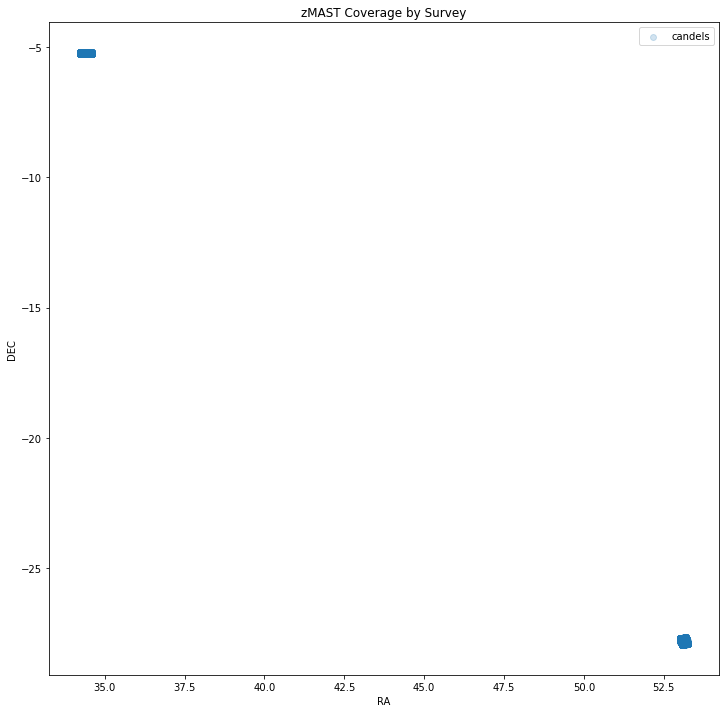

In [2]:
metadata_url = "http://z.mast.stsci.edu/api/v0.1/candels/metadata.json"
r = requests.get(metadata_url)
response = r.json()

catalogs = [r["table"] for r in response["catalogs"]]
plt.figure(figsize=(12,12))

catalog = catalogs[0]
core = catalog.split('_')[0]

print(core)
api_url = "http://z.mast.stsci.edu/api/v0.1/candels?catalog=%s" % (catalog)
r = requests.get(api_url)
response = r.json()
info = response["info"]
data = response["data"]
print(catalog, len(data))
for i in range(len(info)):
    if (info[i]['name']) == 'RA':
        raind = i
    elif (info[i]['name']) == 'DEC':
        decind = i
ras = np.array([d[raind] for d in data])
decs = np.array([d[decind] for d in data])
plt.scatter(ras, decs, label=core, alpha=0.2)
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('zMAST Coverage by Survey')

Now let's look for CANDELS objects in the Hubble Catalog of Variables (HCV). HCV considered all objects with repeat observations, and catalogued those with a high degree of variability between visits. A detailed HCV tutorial can be found here: https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html.

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"

def hcvcone(ra,dec,radius,table="hcvsummary",release="v3",format="csv",magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False,
            **kw):
    """Do a cone search of the HSC catalog (including the HCV)
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hcvsearch(table=table,release=release,format=format,magtype=magtype,
                     columns=columns,baseurl=baseurl,verbose=verbose,**data)


def hcvsearch(table="hcvsummary",release="v3",magtype="magaper2",format="csv",
              columns=None, baseurl=hscapiurl, verbose=False,
           **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{}.{}".format(cat2url(table,release,magtype,baseurl=baseurl),format)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hcvmetadata(table,release,magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hcvmetadata(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table,release,magtype,baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def cat2url(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table,release,magtype)
    if table == "summary":
        url = "{baseurl}/{release}/{table}/{magtype}".format(**locals())
    else:
        url = "{baseurl}/{release}/{table}".format(**locals())
    return url


def checklegal(table,release,magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError("Bad value for release (must be one of {})".format(
            ', '.join(releaselist)))
    if release=="v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions",
                    "hcvsummary", "hcv")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(
            release, ", ".join(tablelist)))
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError("Bad value for magtype (must be one of {})".format(
                ", ".join(magtypelist)))


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position
    """

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


def mastQuery(request, url='https://mast.stsci.edu/api/v0/invoke'):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    url (string): The service URL

    Returns the returned data content
    """
    
    # Encoding the request as a json string
    requestString = json.dumps(request)
    r = requests.post(url, data={'request': requestString})
    r.raise_for_status()
    return r.text

***

In [6]:
# ra = ras.mean() #mean RA of GOODS-North
# dec = decs.mean()
# radius = 0.5 # degrees; note that this is the maximum allowed
t0 = time.time()
# tab = ascii.read(hcvcone(ra,dec,radius,table="hcvsummary"))
tab = ascii.read(hcvsearch(table="hcvsummary", AutoClass=[0,1,2]))
print("Completed in {:.1f} sec".format(time.time()-t0))
# print(ra,dec)
# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

Completed in 2.1 sec


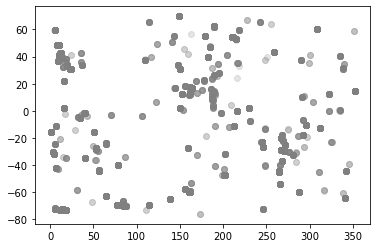

In [7]:
_, unique = np.unique(tab['MatchID'], return_index=True)
plt.scatter(tab[unique]['RA'], tab[unique]['Dec'], color='grey', alpha=0.2)

In [9]:
candidates = tab[tab['MAD'] > 0.2]
candidates

MatchID,Filter,GroupID,SubGroupID,RA,Dec,AutoClass,ExpertClass,VarQualFlag,FilterDetFlag,NumLC,MeanMag,MeanCorrMag,MAD,Chi2
int64,str11,int64,int64,float64,float64,int64,int64,str5,int64,int64,float64,float64,float64,float64
352,ACS_F814W,1040910,26,269.790894,-29.248819,1,0,BACAA,1,29,24.128,24.138,0.2818,39.1437
9456,ACS_F814W,1040910,44,269.841431,-29.200235,0,0,-----,0,7,24.962,24.969,0.2347,9.4246
13872,WFC3_F160W,1043384,0,184.695282,47.339626,0,0,-----,0,10,23.295,23.316,0.2288,47.0090
18472,WFC3_F555W,1039945,2,84.716179,-69.087158,1,0,AAAAC,1,5,24.932,24.937,0.4119,11.6130
20199,WFC3_F555W,1039945,2,84.665932,-69.110413,1,0,BABAB,1,8,23.529,23.531,0.4537,211.3366
20199,WFC3_F656N,1039945,2,84.665932,-69.110413,1,0,AAAAC,0,8,18.783,18.768,0.3671,57.5531
20199,WFC3_F814W,1039945,2,84.665932,-69.110413,1,0,AAAAC,0,8,23.978,23.982,0.3506,28.3748
21690,WFC3_F555W,1039945,2,84.683914,-69.082146,0,0,-----,0,7,23.226,23.230,0.2689,27.0886
21690,WFC3_F656N,1039945,2,84.683914,-69.082146,0,0,-----,0,7,18.096,18.092,0.3928,117.8784


In [10]:
matches = []
i = 0
for gal in tab:
    if ((np.min(abs(gal['RA'] - ras)) < 0.05) and (np.min(abs(gal['Dec'] - decs)) < 0.05)):
        matches.append(i)
    i+=1

In [12]:
tab = tab[matches]

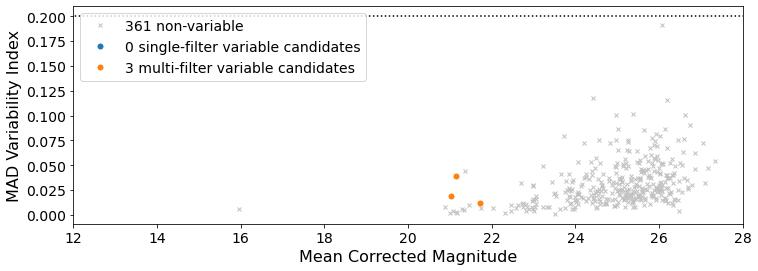

In [13]:
wnovar = np.where(tab['AutoClass']==0)[0]
wsfvc = np.where(tab['AutoClass']==1)[0]
wmfvc = np.where(tab['AutoClass']==2)[0]
x = tab['MeanCorrMag']
y = tab['MAD']
fig = plt.gcf()
fig.set_figwidth(12)
plt.plot(x[wnovar], y[wnovar], 'x', markersize=4, color='silver',
          label='{:,} non-variable'.format(len(wnovar)))
plt.plot(x[wsfvc], y[wsfvc], 'o', markersize=5, 
          label='{:,} single-filter variable candidates'.format(len(wsfvc)))
plt.plot(x[wmfvc], y[wmfvc], 'o', markersize=5, 
          label='{:,} multi-filter variable candidates'.format(len(wmfvc)))
plt.legend(fontsize=14)
plt.hlines(0.2, 11, 29, color='k', linestyles='dotted')
plt.xlim(12,28)
plt.xlabel('Mean Corrected Magnitude', fontsize=16)
plt.ylabel('MAD Variability Index',fontsize=16)
_ = plt.xticks(fontsize=14); _ = plt.yticks(fontsize=14)

In [22]:
cutout_coord = SkyCoord(tab['RA'][0], tab['Dec'][0], unit="deg")
hdulist = Zcut.get_cutouts(coordinates=cutout_coord, size=25)

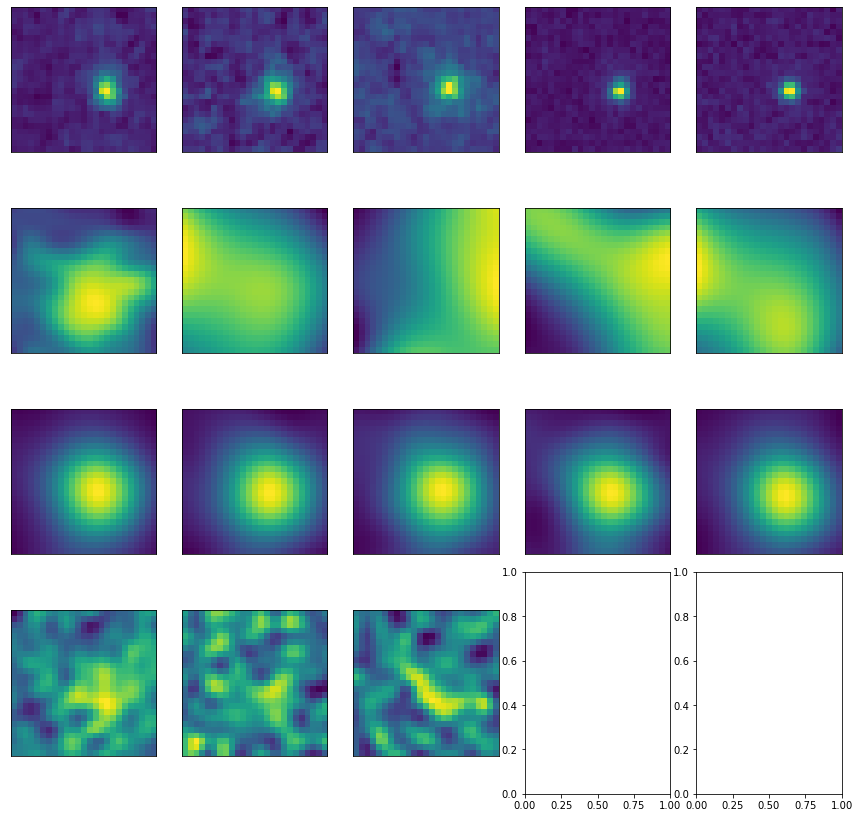

In [34]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize=(12,12))
for i in range(1,len(hdulist[0])):
    ax.flatten()[i-1].imshow(hdulist[0][i].data)
    ax.flatten()[i-1].set_xticks([]); ax.flatten()[i-1].set_yticks([])
plt.tight_layout(h_pad=-1.5, w_pad=-0.5)

## Main Content

The main content of your tutorial should be subdivided into numbered sections with useful, descriptive headings that make sense based on the content. Break sections up with standard Markdown syntax headings:

```
## Section 1

Intro to Section 1

### Subsection 1a

More detailed info about Section 1

## Section 2

A complete thought that's as important as Section 1 but doesn't need subsections.

```

### Loading Data

Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

If the user needs to download data to run the tutorial properly, where possible, use [Astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

First, we want to pull all the observations from the Hubble Source Catalog using astroquery. This is done using the Catalogs module, which readily sorts the many inhomogeneous Hubble observations into specific, neat catalogs like HSC. We will use the query_region function, which needs an (RA, DEC) position for reference. Additionally, it needs a search radius around this coordinate, with the default being 0.2 degrees (12 arcminutes). What should this radius be if we want to pull data from the entire sky?

In [20]:
#radius is distance in degrees from specified coords
# r_max = 180
#we want NumVisits > 1
obs_table = Catalogs.query_region("158.47924 -7.30962", catalog='HSC', radius=50)

In [21]:
obs_table

MatchID,Distance,MatchRA,MatchDec,DSigma,AbsCorr,NumFilters,NumVisits,NumImages,StartTime,StopTime,StartMJD,StopMJD,TargetName,CI,CI_Sigma,KronRadius,KronRadius_Sigma,Extinction,SpectrumFlag,W2_F170W,W2_F170W_MAD,W2_F170W_N,W2_F255W,W2_F255W_MAD,W2_F255W_N,W2_F300W,W2_F300W_MAD,W2_F300W_N,W2_F336W,W2_F336W_MAD,W2_F336W_N,W2_F380W,W2_F380W_MAD,W2_F380W_N,A_F435W,A_F435W_MAD,A_F435W_N,W2_F439W,W2_F439W_MAD,W2_F439W_N,A_F475W,A_F475W_MAD,A_F475W_N,W2_F547M,W2_F547M_MAD,W2_F547M_N,W2_F555W,W2_F555W_MAD,W2_F555W_N,W3_F600LP,W3_F600LP_MAD,W3_F600LP_N,A_F606W,A_F606W_MAD,A_F606W_N,W2_F606W,W2_F606W_MAD,W2_F606W_N,W3_F606W,W3_F606W_MAD,W3_F606W_N,A_F625W,A_F625W_MAD,A_F625W_N,W3_F625W,W3_F625W_MAD,W3_F625W_N,W2_F656N,W2_F656N_MAD,W2_F656N_N,W2_F675W,W2_F675W_MAD,W2_F675W_N,W2_F702W,W2_F702W_MAD,W2_F702W_N,A_F775W,A_F775W_MAD,A_F775W_N,A_F814W,A_F814W_MAD,A_F814W_N,W2_F814W,W2_F814W_MAD,W2_F814W_N,W3_F814W,W3_F814W_MAD,W3_F814W_N,A_F850LP,A_F850LP_MAD,A_F850LP_N,W3_F098M,W3_F098M_MAD,W3_F098M_N,W3_F105W,W3_F105W_MAD,W3_F105W_N,W3_F110W,W3_F110W_MAD,W3_F110W_N,W3_F125W,W3_F125W_MAD,W3_F125W_N,W3_F127M,W3_F127M_MAD,W3_F127M_N,W3_F139M,W3_F139M_MAD,W3_F139M_N,W3_F153M,W3_F153M_MAD,W3_F153M_N,W3_F160W,W3_F160W_MAD,W3_F160W_N
str9,float64,float64,float64,float64,str1,int64,int64,int64,str21,str21,float64,float64,str27,float64,float64,float64,float64,float64,str1,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
28900467,135.2845195764324,157.49939488180465,-5.2758895916828665,0.0,Y,1,1,1,/Date(1321573264273)/,/Date(1321574630273)/,55882.98685499327,55883.00266515976,GRB110312A,2.1069318056106567,0.0,0.2963999807834625,0.0,0.038844410330057144,N,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,25.763399124145508,0.0,1,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0
55810504,135.33887703211872,157.48389519740252,-5.282327616259147,0.0,Y,1,1,1,/Date(1321573264273)/,/Date(1321574630273)/,55882.98685499327,55883.00266515976,GRB110312A,0.9477272629737854,0.0,0.15359999239444733,0.0,0.038844410330057144,N,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,24.49519920349121,0.0,1,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0
55229628,135.3419659955615,157.48748991407615,-5.280531553939175,0.0,Y,1,1,1,/Date(1321573264273)/,/Date(1321574630273)/,55882.98685499327,55883.00266515976,GRB110312A,1.005454564636404,0.0,0.14000000059604645,0.0,0.038844410330057144,N,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,19.358200073242188,0.0,1,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0,nan,nan,0
51107882,135.34704662329085,157.49136720475988,-5.278570747415754,0.0,Y,1,1,1,/Date(1321573264273)/,/Date(1321574630273)/,55882.98685499327,55883.00266515976,GRB110312A,0.6124999712813984,0.0,0.1563999950885

Text(0.5, 1.0, 'Field 2')

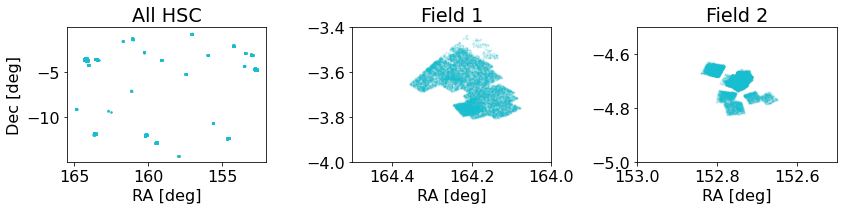

In [73]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
ax[0].plot(obs_table['MatchRA'], obs_table['MatchDec'], 'bo', markersize=1, alpha=0.1, color='tab:cyan')
ax[1].plot(obs_table['MatchRA'], obs_table['MatchDec'], 'bo', markersize=1, alpha=0.1, color='tab:cyan')
ax[2].plot(obs_table['MatchRA'], obs_table['MatchDec'], 'bo', markersize=1, alpha=0.1, color='tab:cyan')
ax[1].set_xlim(164,164.5); ax[1].set_ylim(-4,-3.4)
ax[2].set_xlim(152.5,153); ax[2].set_ylim(-5,-4.5)
for a in ax.flatten(): 
    a.invert_xaxis()
    a.set_xlabel('RA [deg]')
ax[0].set_ylabel('Dec [deg]')
plt.tight_layout()
ax[0].set_title('All HSC')
ax[1].set_title('Field 1')
ax[2].set_title('Field 2')
# plt.xlim(163,165); plt.ylim(-5,-3)

The coverage is sparse when you look across the entire sky; the HST field of view is 0.003$^{\circ^2}$ even for the widest camers. However, it had several dedicated surveys that scanned small patches with exquisite spatial resolution. You will find thousands, if not millions, of sources in each of these fields. 

Now, let us select objects with more than two observations, since we need that to figure out if they are changing over time. Let's save this catalog, since, as you certainly noticed, pulling the entire catalog takes time. 

In [27]:
repeats = obs_table[obs_table['NumVisits'] > 2]
repeats.write('hsc_repeats.dat', format='ascii')

Next, we want to cross-match these objects with zMAST. This stores images and other data products for the surveys:     CANDELS, GOODS, HFF-DEEPSPACE and 3D-HST.

In [33]:
coords = SkyCoord(ra=repeats['MatchRA'], dec=repeats['MatchDec'], unit = (u.deg, u.deg))
coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(155.63851262, -10.62082238), (155.63486561, -10.62343148),
     (155.64047814, -10.62943255), ..., (164.31209622,  -3.58218178),
     (164.30790962,  -3.57556317), (164.31544727,  -3.58655999)]>

In [74]:
Catalogs.query_region?

In [70]:
#size in pixels
i=0
cross = []
for coord in coords[:1000]:
    hdulist = Zcut.get_surveys(coordinates=coord)
    print(i, coord)
    if len(hdulist):

        cross.append(coord)
    i+=1

0 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63851262, -10.62082238)>
1 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63486561, -10.62343148)>
2 <SkyCoord (ICRS): (ra, dec) in deg
    (155.64047814, -10.62943255)>
3 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63673826, -10.62897515)>
4 <SkyCoord (ICRS): (ra, dec) in deg
    (155.62834751, -10.62243788)>
5 <SkyCoord (ICRS): (ra, dec) in deg
    (155.62875614, -10.62477106)>
6 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63801403, -10.63313472)>
7 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63734953, -10.63447649)>
8 <SkyCoord (ICRS): (ra, dec) in deg
    (155.63379123, -10.63695166)>
9 <SkyCoord (ICRS): (ra, dec) in deg
    (155.6346468, -10.63774939)>
10 <SkyCoord (ICRS): (ra, dec) in deg
    (160.16007021, -11.9194846)>
11 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44173771, -12.7008163)>
12 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45460134, -12.70049985)>
13 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44126648, -12.70306125)>
14 <S

115 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45003605, -12.71115215)>
116 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45407425, -12.71052155)>
117 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46219637, -12.70923315)>
118 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47636164, -12.70694693)>
119 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48128436, -12.70609763)>
120 <SkyCoord (ICRS): (ra, dec) in deg
    (159.43773428, -12.71377696)>
121 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46885229, -12.70845376)>
122 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46035353, -12.71011437)>
123 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47553682, -12.70756065)>
124 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48633996, -12.70562193)>
125 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47790362, -12.70730964)>
126 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46293023, -12.71002059)>
127 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45477067, -12.71148584)>
128 <SkyCoord (ICRS): (ra, dec) in deg
    (159.437

228 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47673958, -12.71453251)>
229 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47165538, -12.71548391)>
230 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44036067, -12.72104171)>
231 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46623496, -12.71654611)>
232 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48908732, -12.7126272)>
233 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49160235, -12.71222708)>
234 <SkyCoord (ICRS): (ra, dec) in deg
    (159.43603371, -12.72213574)>
235 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45519705, -12.7188429)>
236 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44892318, -12.72005202)>
237 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4360688, -12.72227301)>
238 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45893391, -12.71834339)>
239 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48805042, -12.71334899)>
240 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47985157, -12.71484414)>
241 <SkyCoord (ICRS): (ra, dec) in deg
    (159.493089

341 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45662947, -12.7259742)>
342 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49390245, -12.7194011)>
343 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46034522, -12.72574422)>
344 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46236461, -12.72567821)>
345 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46883864, -12.72456296)>
346 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44820071, -12.72822181)>
347 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45899087, -12.72634307)>
348 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4587312, -12.72650961)>
349 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4822645, -12.72250013)>
350 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44183344, -12.72992514)>
351 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4906509, -12.72135868)>
352 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46932165, -12.72521533)>
353 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45483951, -12.72794007)>
354 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48992415

454 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45467819, -12.73579708)>
455 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45647577, -12.73550423)>
456 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44913193, -12.73692935)>
457 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47267871, -12.73287306)>
458 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45476372, -12.7361255)>
459 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45582956, -12.7359558)>
460 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45620316, -12.73598054)>
461 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49233822, -12.72956248)>
462 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44268746, -12.73849222)>
463 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49411237, -12.72943572)>
464 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49248159, -12.72974063)>
465 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47268461, -12.73332656)>
466 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44077749, -12.73896776)>
467 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45159

567 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47214414, -12.7404782)>
568 <SkyCoord (ICRS): (ra, dec) in deg
    (159.43756201, -12.74657135)>
569 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44153938, -12.74590658)>
570 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45859226, -12.74306514)>
571 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48849025, -12.73793205)>
572 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4872116, -12.73828025)>
573 <SkyCoord (ICRS): (ra, dec) in deg
    (159.43487018, -12.74749812)>
574 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48290644, -12.73915015)>
575 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45845854, -12.74380764)>
576 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45342044, -12.74471335)>
577 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46287845, -12.74306348)>
578 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48597253, -12.73903016)>
579 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48452062, -12.7393106)>
580 <SkyCoord (ICRS): (ra, dec) in deg
    (159.471115

680 <SkyCoord (ICRS): (ra, dec) in deg
    (159.43813536, -12.75513671)>
681 <SkyCoord (ICRS): (ra, dec) in deg
    (159.49001924, -12.7461578)>
682 <SkyCoord (ICRS): (ra, dec) in deg
    (159.46280988, -12.75106837)>
683 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44326387, -12.75464812)>
684 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48887138, -12.74668535)>
685 <SkyCoord (ICRS): (ra, dec) in deg
    (159.47329261, -12.74964895)>
686 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45741627, -12.75244218)>
687 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4365825, -12.75603299)>
688 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44434629, -12.75476599)>
689 <SkyCoord (ICRS): (ra, dec) in deg
    (159.48995463, -12.74680493)>
690 <SkyCoord (ICRS): (ra, dec) in deg
    (159.45881707, -12.75235367)>
691 <SkyCoord (ICRS): (ra, dec) in deg
    (159.4707505, -12.75035587)>
692 <SkyCoord (ICRS): (ra, dec) in deg
    (159.44030088, -12.75585176)>
693 <SkyCoord (ICRS): (ra, dec) in deg
    (159.449044

794 <SkyCoord (ICRS): (ra, dec) in deg
    (152.78959074, -4.7776297)>
795 <SkyCoord (ICRS): (ra, dec) in deg
    (152.79144947, -4.77353179)>
796 <SkyCoord (ICRS): (ra, dec) in deg
    (152.79495443, -4.76569823)>
797 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77078161, -4.81866993)>
798 <SkyCoord (ICRS): (ra, dec) in deg
    (152.79276893, -4.76987801)>
799 <SkyCoord (ICRS): (ra, dec) in deg
    (152.79393092, -4.76711659)>
800 <SkyCoord (ICRS): (ra, dec) in deg
    (152.7893446, -4.7770341)>
801 <SkyCoord (ICRS): (ra, dec) in deg
    (152.78943832, -4.77606377)>
802 <SkyCoord (ICRS): (ra, dec) in deg
    (152.78994673, -4.77485923)>
803 <SkyCoord (ICRS): (ra, dec) in deg
    (152.7911319, -4.771906)>
804 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77067298, -4.81564121)>
805 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77297035, -4.81038819)>
806 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77121637, -4.81310324)>
807 <SkyCoord (ICRS): (ra, dec) in deg
    (152.79272255, -4.76552712)

910 <SkyCoord (ICRS): (ra, dec) in deg
    (152.83153828, -4.66553137)>
911 <SkyCoord (ICRS): (ra, dec) in deg
    (152.83089472, -4.66674107)>
912 <SkyCoord (ICRS): (ra, dec) in deg
    (152.76899622, -4.80023779)>
913 <SkyCoord (ICRS): (ra, dec) in deg
    (152.76957265, -4.79876536)>
914 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77673138, -4.78269707)>
915 <SkyCoord (ICRS): (ra, dec) in deg
    (152.7777299, -4.78036551)>
916 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77903696, -4.77748461)>
917 <SkyCoord (ICRS): (ra, dec) in deg
    (152.76659319, -4.80496309)>
918 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77048896, -4.79570881)>
919 <SkyCoord (ICRS): (ra, dec) in deg
    (152.78849843, -4.75606767)>
920 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77795263, -4.77917521)>
921 <SkyCoord (ICRS): (ra, dec) in deg
    (152.77841587, -4.778147)>
922 <SkyCoord (ICRS): (ra, dec) in deg
    (152.76494078, -4.80802152)>
923 <SkyCoord (ICRS): (ra, dec) in deg
    (152.78138762, -4.771490

In [71]:
cross #why??

[]

### File Information

Explain pertinent details about the file you've just downloaded. For example, if working with Kepler light curves, explain what's in the different file extensions:

```
- No. 0 (Primary): This HDU contains metadata related to the entire file.
- No. 1 (Light curve): This HDU contains a binary table that holds data like
  flux measurements and times. We will extract information from here when we
  define the parameters for the light curve plot.
- No. 2 (Aperture): This HDU contains the image extension with data collected
  from the aperture. We will also use this to display a bitmask plot that
  visually represents the optimal aperture used to create the SAP_FLUX column in
  HDU1.

```

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [The Hubble Catalog of Variables](https://arxiv.org/pdf/1909.10757.pdf)

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author:** Jessie Blogs, Archive Scientist.  
**Updated On:** YYYY-MM-DD

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 